# Springboard--DSC Program

# Capstone Project 1 - Exploratory Data Analysis 
### by Ellen A. Savoye

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Summary

In a previous report, I imported and cleaned the text data from the Kaggle competition 'Jigsaw Unintended Bias in Toxicity Classification'. The text data was converted to lower case and removed emojis, emoticons, punctuation, and special characters. I then created a second data set containing only the subset of data containing identity tags. Both data sets were pickled and imported into this report.

The goal of exploratory data analysis (EDA) here is to uncover anomalies, check assumptions, ask questions, and gather insights with the help of summary statistics and graphical representations. 



# Import packages and data


In [2]:
# !pip install wordcloud
# !pip install kaggle
# !pip install spacy
!pip install swifter
# !pip install tqdm
!pip install dexplot

     |████████████████████████████████| 61kB 3.3MB/s 
     |████████████████████████████████| 604kB 9.6MB/s 
     |████████████████████████████████| 276kB 46.1MB/s 
  Created wheel for locket: filename=locket-0.2.0-cp36-none-any.whl size=4040 sha256=cb82c50a3d67691935121f292549600a29797b20bd5951669efed6dfe8d1016d
  Stored in directory: /root/.cache/pip/wheels/26/1e/e8/4fa236ec931b1a0cdd61578e20d4934d7bf188858723b84698
Successfully built locket
ERROR: distributed 2.11.0 has requirement tornado>=5; python_version < "3.8", but you'll have tornado 4.5.3 which is incompatible.
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1
  Found existing installation: msgpack 0.5.6
    Uninstalling msgpack-0.5.6:
      Successfully uninstalled msgpack-0.5.6
  Found existing installation: distributed 1.25.3
    Uninstalling distributed-1.25.3:
      Successfully uninstalled distributed-1.25.3


In [0]:
import pandas as pd
import numpy as np
import itertools
from collections import Counter

# libraries for NLP
import spacy

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import string
from string import punctuation

import swifter

# libraries for getting and moving data
import os
from os import path
import shutil
from zipfile import ZipFile

# for Images
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline

In [0]:
# Seaborn selections
sns.set_palette("bright")

In [5]:
# google colab only
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
# necessary dependencies for text pre-processing

nlp = spacy.load('en_core_web_sm', parse=True, tag=True, entity=True)
#nlp_vec = spacy.load('en_vecs', parse = True, tag=True, #entity=True)
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

In [0]:
# Set directories
# Google Colab
src = "/content/drive/My Drive/DS-Capstone_1/Code/"
dst = "/content/drive/My Drive/DS-Capstone_1/Data/"

# Local computer
# src = "C:\\Users\\ellen\\Documents\\GitHub\\Data_Science_Career_Track\\Capstone_1\\Code\\"
# dst = "C:\\Users\\ellen\\Documents\\GitHub\\Data_Science_Career_Track\\Capstone_1\\Data\\"

# Work computer
# src = "C:\\Users\\esavoye\\Documents\\GitHub\\Data_Science_Career_Track\\Capstone_1\\Code\\"
# dst = "C:\\Users\\esavoye\\Documents\\GitHub\\Data_Science_Career_Track\\Capstone_1\\Data\\"

# Computer path
# unpickled_df = pd.read_pickle(dst + '/cleaned_train_data.pkl')
# unpickled_df_slimmed = pd.read_pickle(dst + '/slimmed_subset_df.pkl')

# Colab path
unpickled_df = pd.read_pickle(dst + 'cleaned_train_data.pkl')
unpickled_df_slimmed = pd.read_pickle(dst + 'slimmed_subset_df.pkl')


## Quick Check

During data cleaning, I found that approximately 22% of the data had identity tags. For EDA, I created a slimmed subset to explore. My initial check shows, as expected, a lack of nulls.  

In [0]:
unpickled_df_slimmed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 405130 entries, 4 to 1804863
Data columns (total 46 columns):
id                                     405130 non-null int64
target                                 405130 non-null float64
comment_text                           405130 non-null object
severe_toxicity                        405130 non-null float64
obscene                                405130 non-null float64
identity_attack                        405130 non-null float64
insult                                 405130 non-null float64
threat                                 405130 non-null float64
asian                                  405130 non-null float64
atheist                                405130 non-null float64
bisexual                               405130 non-null float64
black                                  405130 non-null float64
buddhist                               405130 non-null float64
christian                              405130 non-null float64
female   

# Questions to ask

1) Is the number of toxic versus non-toxic comments balanced?
  - Is the subset balanced?

2) What is the frequency of words?
  - Are the words with the highest frequency stop words? Do they provide insights?

3) How do the length of comments compare to binned toxicity? i.e. low (0-.33], (0.33-.66], (0.66, 1]
  - To the slimmed dataset?

4) Is there any correlation between the identity any of the labels and target?

5) How many identity labels are populated across each row in the slimmed data set?
  - For each identity label, what is the distribution? Mean? Mode?

6) What words are most prevalent within each toxicity bin? Are they the same across all 3 bins?


### Question 1

Is the number of toxic versus non-toxic comments balanced?
  - Is the subset balanced?

In [0]:
# adding features
# google colab
unpickled_df['word_count'] = unpickled_df['clean_text'].apply(lambda x: len(str(x).split()))
unpickled_df['word_split'] = unpickled_df['clean_text'].apply(lambda x: str(x).split())
unpickled_df['comment_len'] = unpickled_df['clean_text'].astype(str).apply(len)
unpickled_df['target_binary'] = np.where(unpickled_df['target'] >= 0.5, 1, 0)

#regular computer
# unpickled_df['word_count'] = unpickled_df['clean_text'].swifter.apply(lambda x: len(str(x).split()))
# unpickled_df['word_split'] = unpickled_df['clean_text'].swifter.apply(lambda x: str(x).split())
# unpickled_df['comment_len'] = unpickled_df['clean_text'].astype(str).swifter.apply(len)


In [0]:
# Subset of data with identity labels
# google colab
unpickled_df_slimmed['word_count'] = unpickled_df_slimmed['clean_text'].apply(lambda x: len(str(x).split()))
unpickled_df_slimmed['word_split'] = unpickled_df_slimmed['clean_text'].apply(lambda x: str(x).split())
unpickled_df_slimmed['comment_len'] = unpickled_df_slimmed['clean_text'].astype(str).apply(len)
unpickled_df_slimmed['target_binary'] = np.where(unpickled_df_slimmed['target'] >= 0.5, 1, 0)

In [0]:
# Check ratio of non-toxic to toxic records 
toxic_ct = unpickled_df['target_binary'].value_counts()[1]
nontoxic_ct = unpickled_df['target_binary'].value_counts()[0]
total_ct = toxic_ct + nontoxic_ct

print('{:.2%}'.format(toxic_ct/total_ct) + ' of the full data is labelled as toxic')

toxic_ct2 = unpickled_df_slimmed['target_binary'].value_counts()[1]
nontoxic_ct2 = unpickled_df_slimmed['target_binary'].value_counts()[0]
total_ct2 = toxic_ct2 + nontoxic_ct2

print('{:.2%}'.format(toxic_ct2/total_ct2) + ' of the identity subset is labelled as toxic')

8.00% of the full data is labelled as toxic
11.36% of the identity subset is labelled as toxic


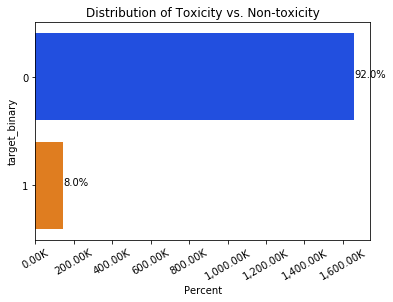

In [0]:
# Full data set
ax = sns.countplot(y="target_binary", data=unpickled_df)
plt.title('Distribution of Toxicity vs. Non-toxicity')
plt.xlabel('Percent')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x/1000) + 'K'))

total = len(unpickled_df['target_binary'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

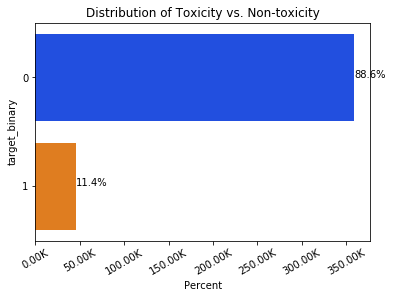

In [0]:
# slimmed data set
ax2 = sns.countplot(y="target_binary", data=unpickled_df_slimmed)
plt.title('Distribution of Toxicity vs. Non-toxicity')
plt.xlabel('Percent')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=30)
ax2.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x/1000) + 'K'))

total = len(unpickled_df_slimmed['target_binary'])
for p in ax2.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax2.annotate(percentage, (x, y))

Neither the full data nor the identity subset are balanced between toxic and non-toxic comments. Given the imbalance, I cannot naively use model accuracy as my only metric for determining success. A confusion matrix, precision and recall should also be used to determine model success.

### Question 2

  - What is the frequency of words?
  - Are the words with the highest frequency stop words? Do they provide insights?

In [0]:
def words_top_n(corpus, n_words = None, vectorizer=None):
    if vectorizer is None:
        print('Vectorizer not selected ... using CountVectorizer (unigram)')
    else:
        print('Vectorizer HAS been selected ... using the provided vectorizer: ', vectorizer)

    if vectorizer is None:
        vectorizer = CountVectorizer()
    
    bag_of_words = vectorizer.fit_transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

    return words_freq[:n_words]

In [0]:
# Unigram
common_words = words_top_n(unpickled_df.clean_text, 20)
for word, freq in common_words:
    print(word, freq)

The value of vectorizer is None ... using CountVectorizer (unigram)
the 4745610
to 2658477
and 2270193
of 2053052
is 1525618
in 1394292
that 1303724
for 958144
you 954547
it 906559
are 753675
not 714946
be 639042
have 619586
on 617176
this 588960
with 585841
they 574212
as 536400
was 445466


The top 20 words, using uni-grams, are mostly stop words which isn't very enlightening. During EDA, I made the decision to keep stop words as they can lend sentiment insight. However, on their own, stop words tend to create noise when looking at uni-grams. Next up, I will be using bi-grams to find the 20 most common pair of words in an attempt to mitigate some of the noise.

In [0]:
# Bi-gram
common_words = words_top_n(unpickled_df.clean_text, 20, CountVectorizer(ngram_range=(2,2)))
for word, freq in common_words:
    print(word, freq)

The value of vectorizer is NOT None ... using the provided vectorizer:  CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(2, 2), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)
of the 421749
in the 344600
to the 208442
to be 175219
for the 156030
on the 154891
it is 150264
and the 142674
is the 102318
that the 101395
with the 100884
is not 92080
they are 89520
this is 88004
from the 81814
you are 80712
at the 80035
by the 79303
if you 78032
there is 76685


In [0]:
# Tri-gram
common_words = words_top_n(unpickled_df.clean_text, 20, CountVectorizer(ngram_range=(3,3)))
for word, freq in common_words:
    print(word, freq)

The value of vectorizer is NOT None ... using the provided vectorizer:  CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(3, 3), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)
there is no 23634
one of the 22366
the rest of 18333
to do with 18205
the fact that 16087
out of the 15381
part of the 14867
in the us 13398
is going to 13224
it is not 12836
be able to 12769
it would be 12301
the united states 11962
we need to 11207
in the world 11109
as well as 10878
you want to 10650
some of the 10021
going to be 10013
this is the 9905


Between the 20 most common uni-, bi-, and tri-grams, it appears tri-grams provide the best insight due to the context stop words contribute. 

## Question 3


How do the length of comments compare to binned toxicity? i.e. low [0-.33], (0.33-.66], (0.66, 1]
  - To the slimmed dataset?

In [0]:
unpickled_df['Toxicity_Bins'] = unpickled_df['target'].apply(lambda x: 'Low' if x <= 0.33 else 'Neutral' if x <= 0.66 else 'High')
unpickled_df_slimmed['Toxicity_Bins'] = unpickled_df_slimmed['target'].apply(lambda x: 'Low' if x <= 0.33 else 'Neutral' if x <= 0.66 else 'High')

In [0]:
unpickled_df.Toxicity_Bins.value_counts()

Low        1599345
Neutral     141091
High         64438
Name: Toxicity_Bins, dtype: int64

In [0]:
unpickled_df_slimmed.Toxicity_Bins.value_counts()

Low        338361
Neutral     48266
High        18503
Name: Toxicity_Bins, dtype: int64

In [0]:
unpickled_df[unpickled_df.Toxicity_Bins == 'Low'].comment_len.max()

1856

In [0]:
unpickled_df[unpickled_df.Toxicity_Bins == 'High'].describe()

,id,target,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,publication_id,parent_id,article_id,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,word_count,comment_len,target_binary
count,6.443800e+04,64438.000000,64438.000000,64438.000000,64438.000000,64438.000000,64438.000000,18503.000000,18503.000000,18503.000000,18503.000000,18503.000000,18503.000000,18503.000000,18503.000000,18503.000000,18503.000000,18503.000000,18503.000000,18503.000000,18503.000000,18503.000000,18503.000000,18503.000000,18503.000000,18503.000000,18503.000000,18503.000000,18503.000000,18503.000000,18503.000000,64438.000000,3.380600e+04,64438.000000,64438.000000,64438.000000,64438.000000,64438.000000,64438.000000,64438.000000,64438.000000,64438.000000,64438.000000,64438.000000,64438.0
mean,3.774513e+06,0.789406,0.038535,0.163240,0.111026,0.693207,0.048128,0.010595,0.003550,0.002212,0.086540,0.001108,0.060740,0.142233,0.004688,0.001039,0.055851,0.003767,0.021368,0.007981,0.134088,0.089202,0.001331,0.001044,0.009099,0.006156,0.002109,0.001454,0.024435,0.009211,0.122127,52.011003,3.674471e+06,282920.031829,0.240479,0.046168,0.113179,2.355722,0.584484,0.044646,2.094882,56.862038,40.489339,222.556504,1.0
std,2.452146e+06,0.091858,0.052395,0.212915,0.198468,0.199005,0.144584,0.083039,0.055026,0.029997,0.266237,0.026257,0.215803,0.316423,0.053612,0.024521,0.213728,0.024955,0.135759,0.066895,0.289778,0.269871,0.014419,0.012261,0.045722,0.037515,0.019280,0.016574,0.121709,0.082634,0.308633,30.278677,2.468420e+06,104022.194944,0.970710,0.245247,0.467176,4.753120,1.822958,0.142388,27.011347,170.619112,37.587632,208.790573,0.0
min,5.985600e+04,0.660377,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.210600e+05,2006.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000,3.000000,1.0
25%,7.976302e+05,0.700000,0.000000,0.000000,0.000000,0.625000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000,7.765885e+05,160142.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,14.000000,78.000000,1.0
50%,5.260946e+06,0.787500,0.017544,0.100000,0.016667,0.712500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,54.000000,5.213989e+06,334542.500000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,53.000000,28.000000,153.000000,1.0
75%,5.811344e+06,0.833333,0.058824,0.200000,0.100000,0.815789,0.014706,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,55.000000,5.790435e+06,368491.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,4.000000,68.000000,53.000000,293.000000,1.0
max,6.333927e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,1.000000,1.000000,1.000000,1.000000,0.300000,0.250000,1.000000,1.000000,0.600000,0.500000,1.000000,1.000000,1.000000,111.000000,6.333648e+06,399529.000000,95.00

In [0]:
list(unpickled_df[unpickled_df.comment_len == 1856].clean_text)

['predatory patrol towing isnt a big subject and there is no advocacy group that is paying any attention to it but the city of portland has completely backed off of enforcing state law where the towing predators are operating on private property and this is commissioner novicks failure hes in charge of towing the city has allowed retriever towing to operate in open violation of ada for years at their nw quimby lot and there is absolutely no provision in city ordinance that takes into account when they tow a mobilitydisabled persons vehicle wheelchair or no wheelchair the person has to get themselves to the tow yard which does not have wheelchair access led by senator avel gordly the legislature enacted important new citizen protections against predatory towing effective january 1 2008 but there is no effective way for portlanders to learn what their rights are other than what the predatory towers themselves tell you a description of the protections has never appeared on the city websit

Text(0, 0.5, 'Density')

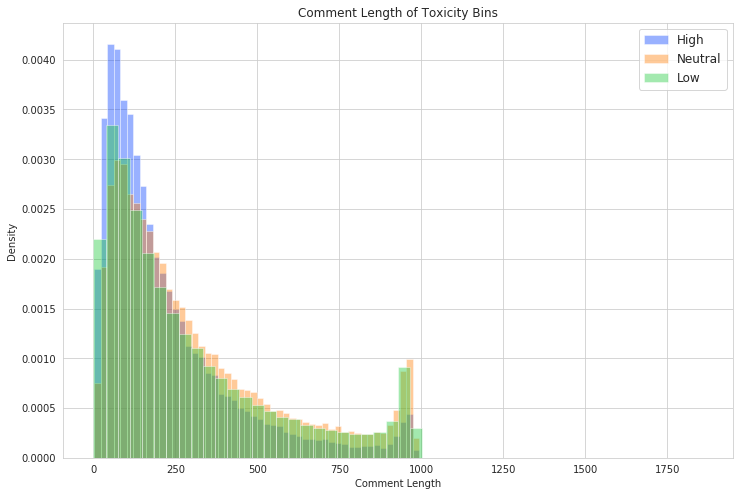

In [0]:
fig_dims = (12, 8)
fig, ax = plt.subplots(figsize=fig_dims)

df = unpickled_df[unpickled_df.Toxicity_Bins == 'High']
sns.distplot(df['comment_len'], kde=False, norm_hist = True, label='High', ax=ax)

df =unpickled_df[unpickled_df.Toxicity_Bins == 'Neutral']
sns.distplot(df['comment_len'], kde=False, norm_hist = True, label='Neutral', ax=ax)

df =unpickled_df[unpickled_df.Toxicity_Bins == 'Low']
sns.distplot(df['comment_len'], kde=False, norm_hist = True, label='Low', ax=ax)

# Plot formatting
plt.legend(prop={'size': 12})
plt.title('Comment Length of Toxicity Bins')
plt.xlabel('Comment Length')
plt.ylabel('Density')

It's a little difficult to glean much from the above graph. The most I can say for certain is the 'high' toxicity bin, 0.66+, has more comments with length between 50-200. Let's split them into 3 subplots to see if that adds any additional information.

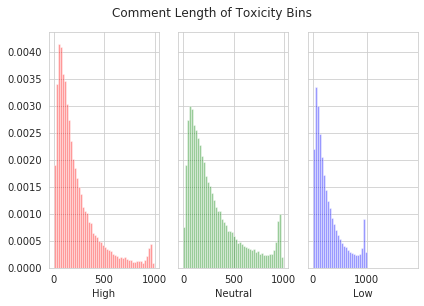

In [0]:
fig, ax =plt.subplots(1,3, sharey=True)#, sharex=True)

df = unpickled_df[unpickled_df.Toxicity_Bins == 'High']
sns.distplot(df['comment_len'], kde=False, norm_hist = True, color = 'r', axlabel='High', ax=ax[0])

df =unpickled_df[unpickled_df.Toxicity_Bins == 'Neutral']
sns.distplot(df['comment_len'], kde=False, norm_hist = True, color = 'g', axlabel='Neutral', ax=ax[1])

df =unpickled_df[unpickled_df.Toxicity_Bins == 'Low']
sns.distplot(df['comment_len'], kde=False, norm_hist = True, color = 'b', axlabel='Low', ax=ax[2])

# Plot formatting
fig.suptitle('Comment Length of Toxicity Bins', y=1.05)
fig.tight_layout()

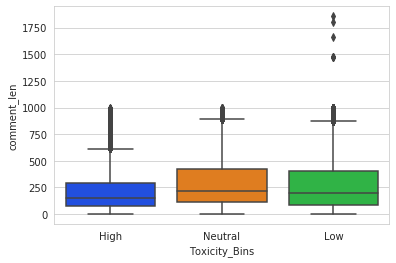

In [0]:
fig, ax = plt.subplots()
sns.boxplot(x="Toxicity_Bins", y="comment_len", data=unpickled_df, order=["High", "Neutral", 'Low'])

In [0]:
low = unpickled_df[unpickled_df.Toxicity_Bins == 'Low'].comment_len.describe()
neutral = unpickled_df[unpickled_df.Toxicity_Bins == 'Neutral'].comment_len.describe()
high = unpickled_df[unpickled_df.Toxicity_Bins == 'High'].comment_len.describe()

In [0]:
print('Toxicity Bin - low: ', low, '\n')
print('Toxicity Bin - neutral: ', neutral, '\n')
print('Toxicity Bin - high: ', high)

Toxicity Bin - low:  count    1.599345e+06
mean     2.860069e+02
std      2.611858e+02
min      0.000000e+00
25%      8.800000e+01
50%      1.930000e+02
75%      4.010000e+02
max      1.856000e+03
Name: comment_len, dtype: float64 

Toxicity Bin - neutral:  count    141091.000000
mean        304.869524
std         255.299488
min           2.000000
25%         110.000000
50%         220.000000
75%         422.000000
max         993.000000
Name: comment_len, dtype: float64 

Toxicity Bin - high:  count    64438.000000
mean       222.556504
std        208.790573
min          3.000000
25%         78.000000
50%        153.000000
75%        293.000000
max        993.000000
Name: comment_len, dtype: float64


The split out histograms shows the 'high' toxicity scores with more short comments in comparison to 'neutral' or 'low'. Interestingly enough, the median of comment length for 'high' is 153 while 'low' and 'neutral' are 193 and 200 respectively. This shows the 3 histograms are skewed to the right with the remaining 50% of the data spread out between ~200 to 1000+ for comment length.

In [0]:
low = unpickled_df_slimmed[unpickled_df_slimmed.Toxicity_Bins == 'Low'].comment_len.describe()
neutral = unpickled_df_slimmed[unpickled_df_slimmed.Toxicity_Bins == 'Neutral'].comment_len.describe()
high = unpickled_df_slimmed[unpickled_df_slimmed.Toxicity_Bins == 'High'].comment_len.describe()

In [0]:
print('Toxicity Bin - low: ', low, '\n')
print('Toxicity Bin - neutral: ', neutral, '\n')
print('Toxicity Bin - high: ', high)

Toxicity Bin - low:  count    338361.000000
mean        340.440184
std         281.907419
min           0.000000
25%         114.000000
50%         248.000000
75%         500.000000
max        1807.000000
Name: comment_len, dtype: float64 

Toxicity Bin - neutral:  count    48266.000000
mean       350.593793
std        269.578162
min          3.000000
25%        137.000000
50%        265.000000
75%        501.000000
max        991.000000
Name: comment_len, dtype: float64 

Toxicity Bin - high:  count    18503.000000
mean       261.451602
std        230.597305
min          3.000000
25%         96.000000
50%        185.000000
75%        346.000000
max        989.000000
Name: comment_len, dtype: float64


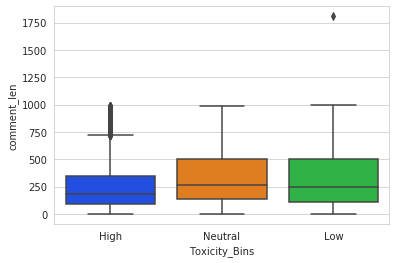

In [0]:
fig, ax = plt.subplots()
sns.boxplot(x="Toxicity_Bins", y="comment_len", data=unpickled_df_slimmed, order=["High", "Neutral", 'Low'])

The identity data set trends mirror the full data set in regards to distribution of comment lengths versus toxicity.

## Question 4

Is there any correlation between the identity any of the labels and target?


In [0]:
subset_col = ['male', 'female', 'transgender', 'other_gender', 'heterosexual', 'homosexual_gay_or_lesbian', 'bisexual', 'other_sexual_orientation',
  'christian', 'jewish', 'muslim', 'hindu', 'buddhist', 'atheist', 'other_religion', 'black', 'white', 'asian', 'latino', 'other_race_or_ethnicity',
  'physical_disability', 'intellectual_or_learning_disability', 'psychiatric_or_mental_illness', 'other_disability', 'target'] 

In [0]:
identity_subset_df = unpickled_df_slimmed[subset_col].copy()

In [0]:
identity_subset_df.head()

,male,female,transgender,other_gender,heterosexual,homosexual_gay_or_lesbian,bisexual,other_sexual_orientation,christian,jewish,muslim,hindu,buddhist,atheist,other_religion,black,white,asian,latino,other_race_or_ethnicity,physical_disability,intellectual_or_learning_disability,psychiatric_or_mental_illness,other_disability,target
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.893617
11,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.440000
19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.500000
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000
31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.912500


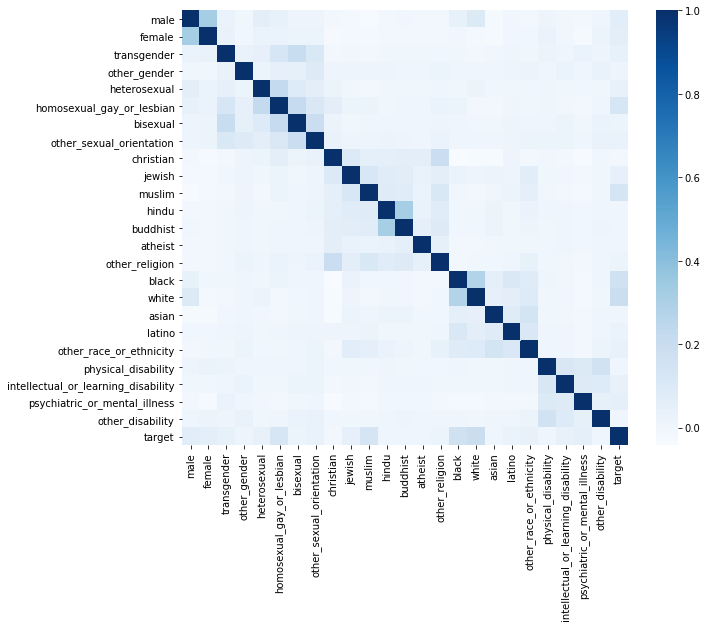

In [0]:
plt.figure(figsize=(10,8))
# sns.heatmap(identity_subset_df.corr(),cmap='viridis',annot=False) 
sns.heatmap(identity_subset_df.corr(),cmap='Blues',annot=False) 

Aside from some correlation between male and female, hindu and buddhist, and black and white, the remaining fields have very little correlation. Target does not have any significant correlation with any of the identity labels. The implication being a positive identification does not imply a positive, toxic, target.

## Question 5

How many identity labels are populated across each row in the slimmed data set?
  - For each identity label, what is the distribution? Mean? Mode?


In [0]:
unpickled_df_slimmed.describe()

,id,target,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,publication_id,parent_id,article_id,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,word_count,comment_len,target_binary
count,4.051300e+05,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.00000,405130.000000,2.350870e+05,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000
mean,3.734479e+06,0.140298,0.006936,0.016321,0.060596,0.099587,0.011613,0.011964,0.003205,0.001884,0.034393,0.001410,0.095268,0.127670,0.003237,0.001457,0.025611,0.001088,0.017863,0.006127,0.108687,0.049460,0.001220,0.000884,0.008248,0.006761,0.001494,0.001356,0.012083,0.006724,0.05695,50.175865,3.704679e+06,281511.298791,0.268356,0.046032,0.112305,2.566929,0.599761,0.012204,6.410900,10.385528,60.243263,338.042307,0.113630
std,2.446379e+06,0.218561,0.028085,0.069201,0.134140,0.185337,0.052903,0.087166,0.050193,0.026077,0.167900,0.030923,0.256671,0.305384,0.045801,0.030862,0.143739,0.016032,0.122145,0.058684,0.267894,0.202459,0.014102,0.011853,0.042717,0.037504,0.015374,0.017505,0.089183,0.069027,0.21596,26.596067,2.454646e+06,103559.032447,1.060748,0.253802,0.463989,4.942980,1.891215,0.062474,37.294163,53.505124,49.310837,278.840257,0.317362
min,5.985600e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,2.000000,6.618700e+04,2006.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,3.000000,0.000000,0.000000,0.000000
25%,8.045102e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,21.000000,7.932285e+05,160309.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,4.000000,21.000000,115.000000,0.000000
50%,5.222179e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,54.000000,5.213037e+06,332002.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4.000000,4.000000,44.000000,246.000000,0.000000
75%,5.781790e+06,0.200000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,54.000000,5.783998e+06,366898.750000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,6.000000,10.000000,88.000000,493.000000,0.000000
max,6.333950e+06,1.000000,0.644363,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.600000,0.750000,1.000000,1.000000,0.750000,1.000000,1

In [0]:
slimmed_identity_tags = unpickled_df_slimmed.copy()

In [0]:
col_names_to_remove = ['id', 'target', 'comment_text', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat', 'created_date',
 'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow', 'sad', 'likes', 'disagree', 'sexual_explicit', 'identity_annotator_count',
 'toxicity_annotator_count', 'clean_text', 'word_count', 'word_split', 'comment_len', 'target_binary', 'Toxicity_Bins']

In [0]:
slimmed_identity_tags = slimmed_identity_tags.drop(col_names_to_remove, axis = 1) 

In [0]:
slimmed_identity_tags.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 405130 entries, 4 to 1804863
Data columns (total 24 columns):
asian                                  405130 non-null float64
atheist                                405130 non-null float64
bisexual                               405130 non-null float64
black                                  405130 non-null float64
buddhist                               405130 non-null float64
christian                              405130 non-null float64
female                                 405130 non-null float64
heterosexual                           405130 non-null float64
hindu                                  405130 non-null float64
homosexual_gay_or_lesbian              405130 non-null float64
intellectual_or_learning_disability    405130 non-null float64
jewish                                 405130 non-null float64
latino                                 405130 non-null float64
male                                   405130 non-null float64
muslim

In [0]:
slimmed_identity_tags.describe()

,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white
count,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.00000
mean,0.011964,0.003205,0.001884,0.034393,0.001410,0.095268,0.127670,0.003237,0.001457,0.025611,0.001088,0.017863,0.006127,0.108687,0.049460,0.001220,0.000884,0.008248,0.006761,0.001494,0.001356,0.012083,0.006724,0.05695
std,0.087166,0.050193,0.026077,0.167900,0.030923,0.256671,0.305384,0.045801,0.030862,0.143739,0.016032,0.122145,0.058684,0.267894,0.202459,0.014102,0.011853,0.042717,0.037504,0.015374,0.017505,0.089183,0.069027,0.21596
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.600000,0.750000,1.000000,1.000000,0.750000,1.000000,1.000000,1.000000,1.00000


Initially, I expected to see NaN or NULL for tags that didn't correspond to the comment of that record. However, in looking at the distributions and info for the tags, I can see that tags which don't apply are identified with a 0 for the relevant records. Given the small range (0-1) and how skewed to 0 the data is (as seen above), I'm going to multiply all the identity tag ratios by 100.

In [0]:
slimmed_identity_tags = slimmed_identity_tags * 100

In [0]:
slimmed_identity_tags.describe()

,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white
count,405130.000000,405130.000000,405130.000000,405130.000000,405130.00000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000
mean,1.196355,0.320502,0.188429,3.439263,0.14105,9.526806,12.767027,0.323704,0.145738,2.561058,0.108810,1.786259,0.612658,10.868674,4.945957,0.122035,0.088383,0.824753,0.676121,0.149368,0.135606,1.208312,0.672367,5.695039
std,8.716616,5.019273,2.607737,16.790023,3.09233,25.667074,30.538373,4.580071,3.086157,14.373918,1.603164,12.214548,5.868400,26.789446,20.245876,1.410179,1.185302,4.271724,3.750375,1.537388,1.750522,8.918316,6.902715,21.596028
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,60.000000,75.000000,100.000000,100.000000,75.000000,100.000000,100.000000,100.000000,100.000000


Even though I multiplied the entire identity tag data set by 100, IQR 25%, 50%, and 75%, are all still 0 for each identity tag. I could change 0 to NaN or NULL but I think that will skew the data in the opposite direction

## Question 6

What words are most prevalent within each toxicity bin? Are they the same across all 3 bins?

In [0]:
unpickled_df_low = unpickled_df[unpickled_df.Toxicity_Bins == 'Low'].clean_text
unpickled_df_neutral = unpickled_df[unpickled_df.Toxicity_Bins == 'Neutral'].clean_text
unpickled_df_high = unpickled_df[unpickled_df.Toxicity_Bins == 'High'].clean_text

In [0]:
# All 'high' reviews:
text_high = " ".join(comment for comment in unpickled_df_high)
print ("There are {} words in the combination of all 'high toxicity' comments.".format(len(text_high)))

# All 'neutral' reviews:
text_neutral = " ".join(comment for comment in unpickled_df_neutral)
print ("There are {} words in the combination of all 'neutral toxicity' comments.".format(len(text_neutral)))

# All 'low' reviews:
text_low = " ".join(comment for comment in unpickled_df_low)
print ("There are {} words in the combination of all 'low toxicity' comments.".format(len(text_low)))

There are 14405533 words in the combination of all 'high toxicity' comments.
There are 43155436 words in the combination of all 'neutral toxicity' comments.
There are 459023008 words in the combination of all 'low toxicity' comments.


In [0]:
# set up for word clouds
def plot_wordcloud(wordcloud):
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

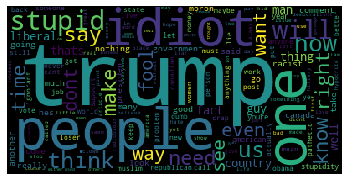

Text(0.5, 0.98, 'Toxicity Bin: High')

<Figure size 432x288 with 0 Axes>

In [0]:
# Create and generate a word cloud image for each bin:
wordcloud_high = WordCloud().generate(text_high)
plot_wordcloud(wordcloud_high)

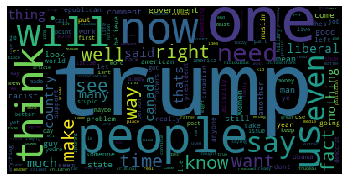

In [0]:
# Create and generate a word cloud image for each bin:
wordcloud_neutral = WordCloud().generate(text_neutral)
plot_wordcloud(wordcloud_neutral)

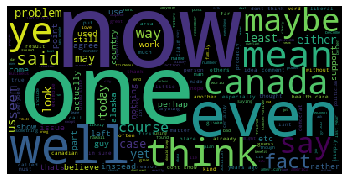

In [0]:
# Create and generate a word cloud image for each bin:
wordcloud_low = WordCloud().generate(text_low)
plot_wordcloud(wordcloud_low)

Between 'high' and 'neutral', trump, one, think, and people stand out the most. In comparison to 'low', only think and one cross all 3 word clouds. The words that stand out in 'low', canada, even, now, and maybe, tend to have a neutral connotation. Comparatively, stupid, idiot, and trump from 'high' have more of a negative connotation, especially in the fraught political environment of society today. By breaking the text into bins and creating word clouds, we are given a snapshot to how negative, neutral, and possibly positive words align with the target value assigned.

# Output

In [0]:
# Create pickle file for use in the future 

unpickled_df_slimmed.to_pickle(dst + '/slimmed_data_w_features.pkl')
unpickled_df.to_pickle(dst + '/full_data_w_features.pkl')